# Введение

Проект посвящён оценке токсичности комментариев: интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Цель - обучение модели, способной классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Для оценки качества используется f1-метрика, по ТЗ значение метрики должно быть не менее 0.75.

План:
1. Обзор данных и предварительная подготовка
- очистка и лемматизация, разделение на выборки, борьба с дисбалансом
2. Обучение моделей с оптимизацией гиперпараметров
- Выбор модели. Тестирование: сравнение полученной модели со случайной
3. Выводы


Данные находятся в файле toxic_comments.csv. Столбец text в нём содержит текст комментария, а toxic — целевой признак.


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Чтение-и-обзор-данных" data-toc-modified-id="Чтение-и-обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Чтение и обзор данных</a></span></li><li><span><a href="#Очистка-и-лемматизация-текстов" data-toc-modified-id="Очистка-и-лемматизация-текстов-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Очистка и лемматизация текстов</a></span></li><li><span><a href="#Подготовка-данных-к-обучению-моделей" data-toc-modified-id="Подготовка-данных-к-обучению-моделей-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка данных к обучению моделей</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Классификатор-SGDC" data-toc-modified-id="Классификатор-SGDC-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Классификатор SGDC</a></span></li></ul></li><li><span><a href="#Проверка" data-toc-modified-id="Проверка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проверка</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

### Чтение и обзор данных

Начнём с чтения и обзора данных

In [1]:
import pandas as pd
import nltk
import spacy
import re
import random
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm

In [2]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('toxic_comments.csv')

In [3]:
#посмотрим на структуру данных визуально
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
#и оценим масштаб
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


В нашем распоряжении практически 160 тысяч комментариев, все размеченные, пропусков в данных нет (о, счастье!). Комментарии на английском языке.

Зато есть непонятная колонка Unnamed:0, которая в первом приближении кажется совпадающей с индексом - и бесполезной.

In [5]:
data['Unnamed: 0'].unique()

array([     0,      1,      2, ..., 159448, 159449, 159450])

Порядковый номер комментария? В любом случае - бесполезно, удаляем

In [6]:
data = data.drop(['Unnamed: 0'], axis=1)

Теперь посмотрим на баланс классов: сколько в выборке положительных и отрицательных комментариев:

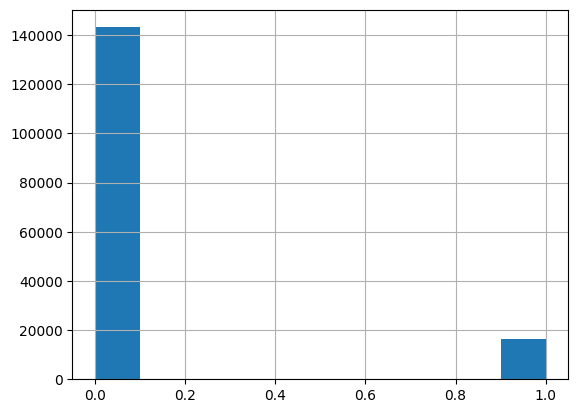

In [7]:
data['toxic'].hist();

Негативных примерно в семь раз меньше позитивных. Учтём это при обучении моделей.

### Очистка и лемматизация текстов

В текстах комментариев видны символы переноса строк, апострофы и тд - очистим от спецсимволов, оставим только латинские буквы, и приведём всё к нижнему регистру.

In [8]:
# отключаем ненужные сущности для экономии времени
disabled_pipes = [ "parser",  "ner"]
nlp = spacy.load('en_core_web_sm', disable=disabled_pipes)
def clean(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    return re.sub(r"[^a-zA-Z ]+", "", text).strip().lower()

def lemmatizer(text):
    tx = nlp(clean(text))
    empty_list = []
    for token in tx:
        empty_list.append(token.lemma_)
    return ' '.join(map(str,empty_list))

In [9]:
#проверим работоспособность лемматизатора на одном предложении
sentence = "The striped\nbats are hanging on their feet for best!"

In [10]:
lemmatizer(sentence)

'the stripe bat be hang on their foot for good'

Получили ожидаемый результат - можно преобразовывать весь датасет

In [11]:
#прогресс-бар для контроля статуса процесса
tqdm.pandas()
data['lemm_text'] = data['text'].progress_apply(lemmatizer)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [12]:
# удаляем столбец с исходным текстом
data = data.drop(['text'], axis=1)

In [13]:
#посмотрим что получилось
data.head()

,toxic,lemm_text
0,0,explanation why the edit make under my usernam...
1,0,daww he match this background colour I m seemi...
2,0,hey man I m really not try to edit war its jus...
3,0,more I can not make any real suggestion on imp...
4,0,you sir be my hero any chance you remember wha...


### Подготовка данных к обучению моделей

Помним, что токсичных комментариев существенно меньше. Можно было бы размножить данные с целевым признаком==1, но попробуем быть ленивыми и будем обучать модели с учётом взвешивания классов.

Для того, чтобы можно было обучать модели, необходимо перевести тексты в числовой формат, то есть провести векторизацию прекдварительно очищенных текстов, а также разбить данные на подвыборки.

Делим на обучающую, валидационную и тестовую в пропорциях 8:1:1 соответственно.
Модели, которые мы обучаем чувствительны к объему обучающих данных. Чем больше слов они увидят в процессе обучения, и оценят их вклад в "токсичность", тем лучше будут модели. А для корректного тестирования и 10% данных вполне достаточно, учитывая немаленький размер датасета.

In [14]:
train_valid, test = train_test_split(data, test_size=.1)
train, valid = train_test_split(train_valid, test_size=.1)

Далее очищаем тексты от стопслов:

In [15]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
X_train = train['lemm_text'].values
X_valid = valid['lemm_text'].values
X_test = test['lemm_text'].values

In [17]:
#обучаем tf-idf на обучающей выборке
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))
tf_idf_model = count_tf_idf.fit_transform(X_train)

In [18]:
X_train = count_tf_idf.transform(X_train)
X_valid = count_tf_idf.transform(X_valid)
X_test = count_tf_idf.transform(X_test)

In [19]:
Y_train = train['toxic']
Y_valid = valid['toxic']
Y_test = test['toxic']

Вывод: данные подготовлены для обучения моделей. Датасет разбит на обучающую, валидационную и тестовую выборки, тексты очищены и преобразованы в векторную форму методом tf-idf.

## Обучение

Алгоритм действий такой: на обучающей выборке проведём обучение моделей, там, где это возможно - с подбором гиперпараметров. На валидационной выборке посчитаем значение выбранной метрики - в данном случае жто метрика F1 в соответствии с ТЗ. Для модели, показавшей наилучшее значение метрики, посчитаем метрику на тестовой выборке - это и будет финальным результатом.

### Логистическая регрессия

In [20]:
#будем сразу оптимизировать гиперпараметры: в данном случае параметр С
f1_logr = 0
c_lr = 5
for param_c in range(1,15,1):
    model = LogisticRegression(random_state=42, solver='liblinear', \
        class_weight='balanced', max_iter=300, C=param_c).fit(X_train, Y_train)
    f1 = f1_score(Y_valid, pd.DataFrame(model.predict(X_valid)))
    if f1>f1_logr:
        f1_logr = f1
        c_lr = param_c

In [21]:
#создадам финальную версию модели лог регрессии и посчитаем метрику на валидационной выборке
model_logr = LogisticRegression(random_state=42, \
        C=param_c, class_weight='balanced', max_iter=200).fit(X_train, Y_train)
f1_logr = f1_score(Y_valid, pd.DataFrame(model_logr.predict(X_valid)))
print(f'Метрика f1 на валидационной выборке для модели логистической регресси = {f1_logr}')

Метрика f1 на валидационной выборке для модели логистической регресси = 0.7771428571428571


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Классификатор SGDC

In [22]:
# снова подбираем гиперпараметры
f1_sgdc = 0
locc_sgdc = 'hinge'
eta_sgdc = 0
for loss in ['hinge', 'log', 'modified_huber']:
    for eta in [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]:
            model = SGDClassifier(loss=loss, eta0=eta,\
                class_weight='balanced').fit(X_train, Y_train)
            f1 = f1_score(Y_valid, pd.DataFrame(model.predict(X_valid)))
            if f1>f1_sgdc:
                f1_sgdc = f1
                locc_sgdc = loss
                eta_sgdc = eta

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

In [23]:
model_sgdc = SGDClassifier(loss=locc_sgdc, eta0=eta_sgdc,\
    class_weight='balanced').fit(X_train, Y_train)

0.760378 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.05, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 12082020}

In [24]:
f1_sgdc = f1_score(Y_valid, pd.DataFrame(model_sgdc.predict(X_valid)))
print(f'Метрика f1 на валидационной выборке для модели SGDC = {f1_sgdc}')

Метрика f1 на валидационной выборке для модели SGDC = 0.7565808932268561


Вывод: обучены модели логистической регрессии и классификатора SGDC. Модель логистической регрессии показывает значение метрики выше требуемого, SGDC чуть уступает. Финальное значение метрики на тестовой выборке посчитаем чуть позже, после сравнения со случайной моделью.

## Проверка

В качестве проверки сравним полученные метрики со случайной моделью, рандомно заполняющей целевой признак нулём или единицей:

In [25]:
pred_rand = np.random.randint(0, 2, Y_valid.shape[0])

In [26]:
f1_rand = f1_score(Y_valid, pd.DataFrame(pred_rand))
print(f'Метрика f1 на валидационной выборке для случайной модели = {f1_rand}')

Метрика f1 на валидационной выборке для случайной модели = 0.17361507709880067


Это значит, что обе наши модели способны классифицировать настроение твита существенно лучше случайной модели. Сведём результаты в финальную таблицу:

In [27]:
models_f1 = pd.DataFrame({
    'Model': ['LogisticRegression', 'SGDC', 'Random'],
    'RMSE': [f1_logr, f1_sgdc, f1_rand],
})

In [28]:
models_f1

,Model,RMSE
0,LogisticRegression,0.777143
1,SGDC,0.756581
2,Random,0.173615


Видно, что модель логистической регрессии чуть лучше - её и выбираем. Считаем финальное значение метрики на тестовой выборке:

In [29]:
f1_logr_final = f1_score(Y_test, pd.DataFrame(model_logr.predict(X_test)))
print(f'Метрика f1 на тестовой выборке для модели логистической регресси = {f1_logr_final:.3}')

Метрика f1 на тестовой выборке для модели логистической регресси = 0.76


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Молодец:
    
  - выбрана лучшая модель
  - тестирование произведено корректно
  - достигнута метрика f1 выше 0,75 на тестовой выборке
</div>


## Выводы

Работа посвящена обучению модели, способной спрогнозировать тональность твита - положительную или негативную.
Прежде всего проведено чтение и осмотр датасета: в нашем распоряжении примерно 160тысяч твитов на английском языке, пропусков нет. Текст был очищен и лемматизирован, затем приведён к векторному виду с помощью tf-idf метода.

На получившихся признаках обучены две модели - логистическая регрессия и классификатор SGDC. Обе показали качество выше требуемого на валидационной выборке. Выполнено сравнение со случайной моделью - обе модели демонстрируют существенно более высокое значение метрики. Ввиду простоты и более высокой скорости выбрана модель логистической регрессии, финальное значение метрики на тестовой выборке = 0.76, что удовлетворяет условиям ТЗ.